In [ ]:
import scipy.io.wavfile as wav
import numpy as np
from tempfile import TemporaryFile
import os
import pickle
import random 
import operator
import math
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.python.keras import utils
from keras.utils import to_categorical
import tensorflow as tf


# Loading data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
#drive.flush_and_unmount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
content_path='/content/gdrive/Shared drives/Data 255/genres/allfiles'

# Extracting an Audio Signal

In [ ]:
# Extracting the wave, "y", and sampling rate, "sr", of the audio file
y, sr = librosa.load('/content/gdrive/Shared drives/Data 255/genres/allfiles/blues.00000.wav')

In [ ]:
# Checking the shape of the wave
y.shape

(661794,)

In [ ]:
# Checking the sampling rate
sr

22050

For audio, the quantity that varies is air pressure.
We can represent a signal digitally by taking samples of the air pressure over time.
Librosa is a python library that allows us to extract waveforms from audio files along with several other features


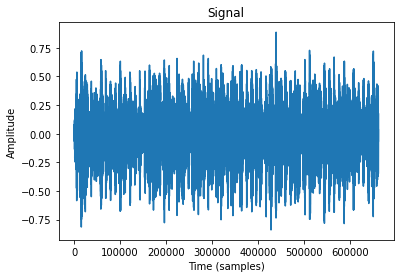

In [ ]:
# Plotting the wave
plt.plot(y);
plt.title('Signal');
plt.xlabel('Time (samples)');
plt.ylabel('Amplitude');


### Fast Fourier Transform (FFT)


An audio signal is comprised of several single-frequency sound waves. When taking samples of the signal over time, we only capture the resulting amplitudes. The Fourier transform is a mathematical formula that allows us to decompose a signal into it’s individual frequencies and the frequency’s amplitude. In other words, it converts the signal from the time domain into the frequency domain. The result is called a spectrum. The fast Fourier transform is an efficient way to compute the Fourier transform.



In [ ]:
# Computing the fast Fourier transform on a single short time window of length 2048 (standard for music audio)
n_fft = 2048
ft = np.abs(librosa.stft(y[:n_fft], hop_length = n_fft+1))

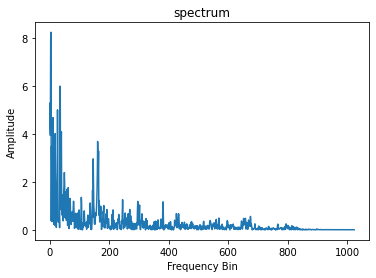

In [ ]:
# Plotting the signal after applying the FFT
plt.plot(ft);
plt.title('spectrum');
plt.xlabel('Frequency Bin');
plt.ylabel('Amplitude');

### Mel Spectrograms¶

**Spectrograms** are a way to visually represent a signal's loudness, or amplitude, as it varies over time at different frequencies. The horizontal axis is time, the vertical axis is frequency, and the color is amplitude. It is calculated using the fast Fourier transform on short time windows of the signal and transforming the vertical axis (frequency) to log scale and the colored axis (amplitude) to decibals. Now, what about the "mel" part? Humans are better at detecting differences in lower frequencies than higher frequencies. The mel scale transforms the frequency scale such that sounds at equal distances from each other also sound equal in distance. A mel spectrogram is a spectrogram where the frequencies are converted to the mel scale.



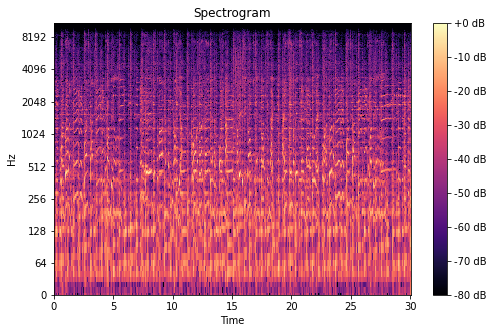

In [ ]:
# Computing the spectrogram
spec = np.abs(librosa.stft(y, hop_length=512))
spec = librosa.amplitude_to_db(spec, ref=np.max) # converting to decibals

# Plotting the spectrogram
plt.figure(figsize=(8,5));
librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');
plt.title('Spectrogram');

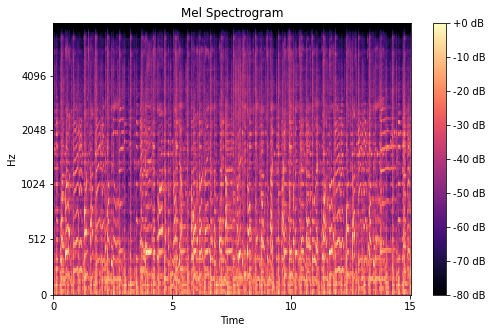

In [ ]:
# Computing the mel spectrogram
spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
spect = librosa.power_to_db(spect, ref=np.max) # Converting to decibals

# Plotting the mel spectrogram
plt.figure(figsize=(8,5))
librosa.display.specshow(spect, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram');
plt.colorbar(format='%+2.0f dB');

### Mel Frequency Cepstral Coefficients (MFCC)


MMCCs are commonly used features in the field of music information retrieval (MIR). They are tyically used to measure timbre.

In [ ]:
# Extracting mfccs from the audio signal
mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=512, n_mfcc=13)

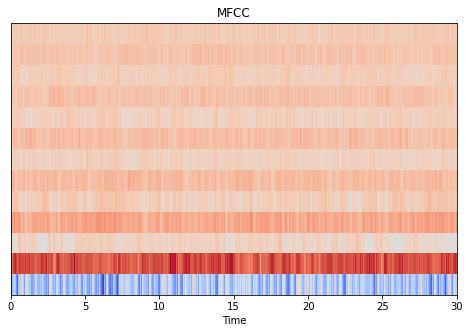

In [ ]:
# Displaying the mfccs
plt.figure(figsize=(8,5));
librosa.display.specshow(mfcc, x_axis='time');
plt.title('MFCC');

In [ ]:
# Scaling the mfccs
mfccscaled = np.mean(mfcc.T, axis=0)
mfccscaled

array([-113.57065 ,  121.57179 ,  -19.168142,   42.36642 ,   -6.364664,
         18.623499,  -13.704891,   15.34315 ,  -12.27411 ,   10.976572,
         -8.326573,    8.803793,   -3.6723  ], dtype=float32)

#Read and Extract Mel Spectrograms
(Checking the Size of the Mel Spectrograms)


In order to feed the mel spectrogram data into a neural network, they must all be the same size, so I check that here.

In [ ]:
# Creating an empty list to store sizes in
sizes = []

for file in os.scandir('/content/gdrive/Shared drives/Data 255/genres/allfiles'):

# Looping through each audio file
        
    # Loading in the audio file
    y, sr = librosa.core.load(file)
        
    # Computing the mel spectrograms
    spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
    spect = librosa.power_to_db(spect, ref=np.max)
    
    # Adding the size to the list
    sizes.append(spect.shape)
    
# Checking if all sizes are the same
print(f'The sizes of all the mel spectrograms in our data set are equal: {len(set(sizes)) == 1}')

# Checking the max size
print(f'The maximum size is: {max(sizes)}')

The sizes of all the mel spectrograms in our data set are equal: False
The maximum size is: (128, 660)


sizes are not the same, so we will have to pad the smaller arrays with zeros to make them all the same size.

In [ ]:
def extract_mel_spectrogram(directory):
 
    
    # Creating empty lists for mel spectrograms and labels
    labels = []
    mel_specs = []
    
    
    # Looping through each file in the directory
    for file in os.scandir(directory):
        
        # Loading in the audio file
        y, sr = librosa.core.load(file)
        
        # Extracting the label and adding it to the list
        label = str(file).split('.')[0][11:]
        labels.append(label)
        
        # Computing the mel spectrograms
        spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
        spect = librosa.power_to_db(spect, ref=np.max)
        
        # Adjusting the size to be 128 x 660
        if spect.shape[1] != 660:
            spect.resize(128,660, refcheck=False)
            
        # Adding the mel spectrogram to the list
        mel_specs.append(spect)
        
    # Converting the list or arrays to an array
    X = np.array(mel_specs)
    
    # Converting labels to numeric values
    labels = pd.Series(labels)
    label_dict = {
        'jazz': 0,
        'reggae': 1,
        'rock': 2,
        'blues': 3,
        'hiphop': 4,
        'country': 5,
        'metal': 6,
        'classical': 7,
        'disco': 8,
        'pop': 9
    }
    y = labels.map(label_dict).values
    
    # Returning the mel spectrograms and labels
    return X, y

In [ ]:
# Using the function to read and extract mel spectrograms from the GTZAN Genre Dataset audio files
X, y = extract_mel_spectrogram(content_path)

In [ ]:
print(X[0].shape)
print(X[1].shape)

(128, 660)
(128, 660)


# Modeling

### Data Preprocessing

In [ ]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=.3)

In [ ]:
X_train.min()

-80.0

In [ ]:
# Normalize training data. Because data is in [-80,0], we divide it by -80 to tranform it into [0,1] for efficient calculations
X_train /= -80
X_test /= -80

In [ ]:
# Reshaping images to be 128 x 660 x 1, where the 1 represents the single color channel
X_train = X_train.reshape(X_train.shape[0], 128, 660, 1)
X_test = X_test.reshape(X_test.shape[0], 128, 660, 1)


In [ ]:
# One hot encoding our labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [ ]:
print(len(X_test))
print(X_test[0])


300
[[[ 0.5282307 ]
  [ 0.53067863]
  [ 0.24316566]
  ...
  [ 0.24349388]
  [ 0.20059252]
  [ 0.03872235]]

 [[ 0.12885901]
  [ 0.21431322]
  [ 0.3144941 ]
  ...
  [ 0.16404378]
  [ 0.27603212]
  [ 0.30626884]]

 [[ 0.24098463]
  [ 0.21317038]
  [ 0.23366919]
  ...
  [ 0.3312789 ]
  [ 0.11891432]
  [ 0.13321722]]

 ...

 [[ 1.        ]
  [ 1.        ]
  [ 1.        ]
  ...
  [-0.        ]
  [-0.        ]
  [-0.        ]]

 [[-0.        ]
  [-0.        ]
  [-0.        ]
  ...
  [-0.        ]
  [-0.        ]
  [-0.        ]]

 [[-0.        ]
  [-0.        ]
  [-0.        ]
  ...
  [-0.        ]
  [-0.        ]
  [-0.        ]]]


## Feed Forward Neural Network -FFNN

In [ ]:
# Initializing a random seed for replication purposes
np.random.seed(23456)

# Initiating an empty neural network
model = Sequential()

# Adding a flattened layer to input our image data
model.add(Flatten(input_shape = (128, 660, 1)))

# Adding a dense layer with 135 neurons
model.add(Dense(135, activation='relu'))

# Adding a dense layer with 120 neurons
model.add(Dense(120, activation='relu'))

# Adding a dense layer with 100 neurons
model.add(Dense(100, activation='relu'))

# Adding an output layer
model.add(Dense(10, activation='softmax'))

# Compiling our neural network
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 84480)             0         
_________________________________________________________________
dense (Dense)                (None, 135)               11404935  
_________________________________________________________________
dense_1 (Dense)              (None, 120)               16320     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               12100     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 11,434,365
Trainable params: 11,434,365
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fitting our neural network
history = model.fit(X_train,
                    y_train, 
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    epochs=15)

Epoch 1/15
22/22 [==============================] - 3s 112ms/step - loss: 20.9807 - accuracy: 0.0910 - val_loss: 6.3438 - val_accuracy: 0.1133
Epoch 2/15
22/22 [==============================] - 2s 86ms/step - loss: 5.5355 - accuracy: 0.1456 - val_loss: 3.5405 - val_accuracy: 0.1033
Epoch 3/15
22/22 [==============================] - 2s 86ms/step - loss: 2.7938 - accuracy: 0.1787 - val_loss: 2.5168 - val_accuracy: 0.2233
Epoch 4/15
22/22 [==============================] - 2s 85ms/step - loss: 2.2876 - accuracy: 0.2403 - val_loss: 2.3306 - val_accuracy: 0.2133
Epoch 5/15
22/22 [==============================] - 2s 84ms/step - loss: 2.3021 - accuracy: 0.2870 - val_loss: 2.3265 - val_accuracy: 0.2700
Epoch 6/15
22/22 [==============================] - 2s 84ms/step - loss: 2.0809 - accuracy: 0.2953 - val_loss: 2.3929 - val_accuracy: 0.1700
Epoch 7/15
22/22 [==============================] - 2s 85ms/step - loss: 2.0065 - accuracy: 0.3353 - val_loss: 2.1970 - val_accuracy: 0.3533
Epoch 8/15


In [ ]:
# Making predictions from the ffnn model
predictions = model.predict(X_test)

In [ ]:
print(f'Loss and accuracy: {model.evaluate(X_test, y_test)}') # loss and accuracy

10/10 [==============================] - 0s 23ms/step - loss: 1.7750 - accuracy: 0.3333
Loss and accuracy: [1.7750425338745117, 0.3333333432674408]


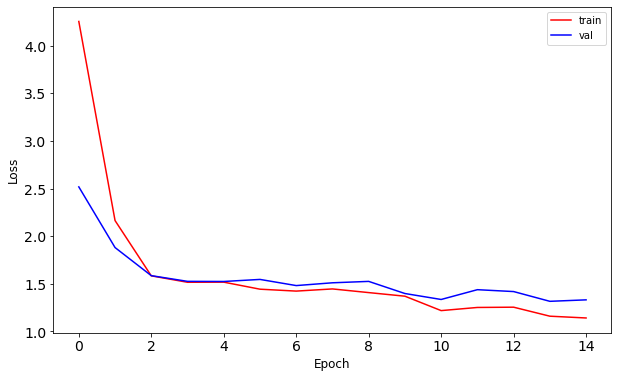

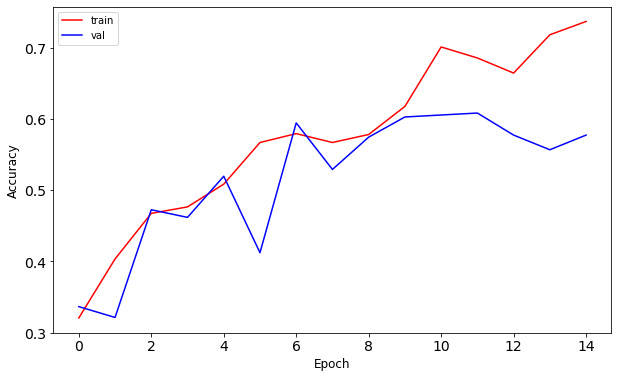

In [ ]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=12)
ax.set_ylabel(r'Loss', fontsize=12)
ax.legend()
ax.tick_params(labelsize=14)

# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['accuracy']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_accuracy']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=12)
ax.set_ylabel(r'Accuracy', fontsize=12)
ax.legend()
ax.tick_params(labelsize=14)

## CNN

In [ ]:
# Initializing a random seed for replication purposes
np.random.seed(23456)
tf.random.set_seed(123)

# Initiating an empty neural network
cnn_model = Sequential(name='cnn_1')

# Adding convolutional layer
cnn_model.add(Conv2D(filters=32,
                     kernel_size=(2,3),
                     activation='relu',
                     input_shape=(128,660,1)))

# Adding max pooling layer
cnn_model.add(MaxPooling2D(pool_size=(2,3)))

# Adding convolutional layer
cnn_model.add(Conv2D(filters=24,
                     kernel_size=(2,3),
                     activation='relu'))

# Adding max pooling layer
cnn_model.add(MaxPooling2D(pool_size=(2,3)))

# Adding a flattened layer to input our image data
cnn_model.add(Flatten())

# Adding a dense layer with 64 neurons
cnn_model.add(Dense(64, activation='relu'))

# Adding a dropout layer for regularization
cnn_model.add(Dropout(0.25))

# Adding an output layer
cnn_model.add(Dense(10, activation='softmax'))

# Compiling our neural network
cnn_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [ ]:
# Checking the model summary
cnn_model.summary()

Model: "cnn_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 127, 658, 32)      224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 219, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 217, 24)       4632      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 72, 24)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 53568)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                3428416   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0     

In [ ]:
# Fitting our neural network
history = cnn_model.fit(X_train,
                        y_train, 
                        batch_size=32,
                        validation_data=(X_test, y_test),
                        epochs=15)

Epoch 1/15
22/22 [==============================] - 38s 2s/step - loss: 3.1397 - accuracy: 0.1013 - val_loss: 2.3016 - val_accuracy: 0.1600
Epoch 2/15
22/22 [==============================] - 36s 2s/step - loss: 2.3009 - accuracy: 0.1378 - val_loss: 2.2957 - val_accuracy: 0.1333
Epoch 3/15
22/22 [==============================] - 36s 2s/step - loss: 2.2710 - accuracy: 0.1582 - val_loss: 2.2257 - val_accuracy: 0.2200
Epoch 4/15
22/22 [==============================] - 36s 2s/step - loss: 2.2008 - accuracy: 0.2476 - val_loss: 2.0026 - val_accuracy: 0.3633
Epoch 5/15
22/22 [==============================] - 37s 2s/step - loss: 1.9712 - accuracy: 0.3135 - val_loss: 1.8326 - val_accuracy: 0.3333
Epoch 6/15
22/22 [==============================] - 37s 2s/step - loss: 1.7241 - accuracy: 0.4156 - val_loss: 1.7503 - val_accuracy: 0.3600
Epoch 7/15
22/22 [==============================] - 37s 2s/step - loss: 1.6579 - accuracy: 0.4172 - val_loss: 1.6279 - val_accuracy: 0.4533
Epoch 8/15
22/22 [==

In [ ]:
# Making predictions from the cnn model
predictions = cnn_model.predict(X_test, verbose=1)


10/10 [==============================] - 4s 435ms/step


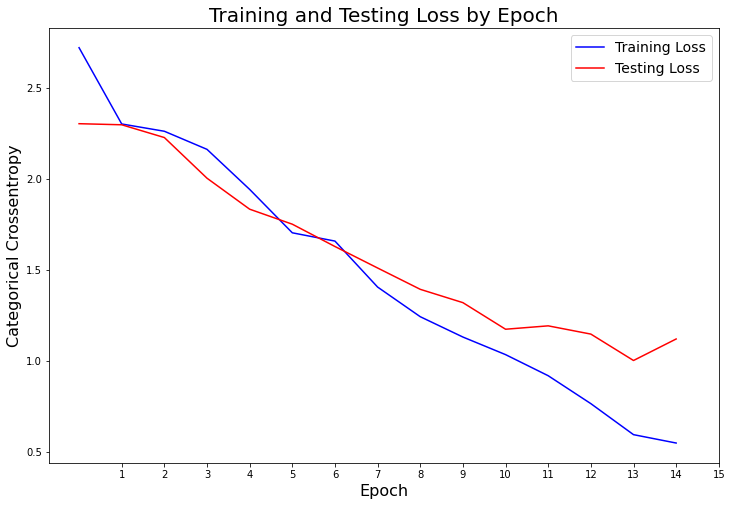

In [ ]:
# The code in this cell was adapted from a lecture at General Assembly

# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(test_loss, label='Testing Loss', color='red')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 20)
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Categorical Crossentropy', fontsize = 16)
plt.xticks(range(1,16), range(1,16))
plt.legend(fontsize = 14);

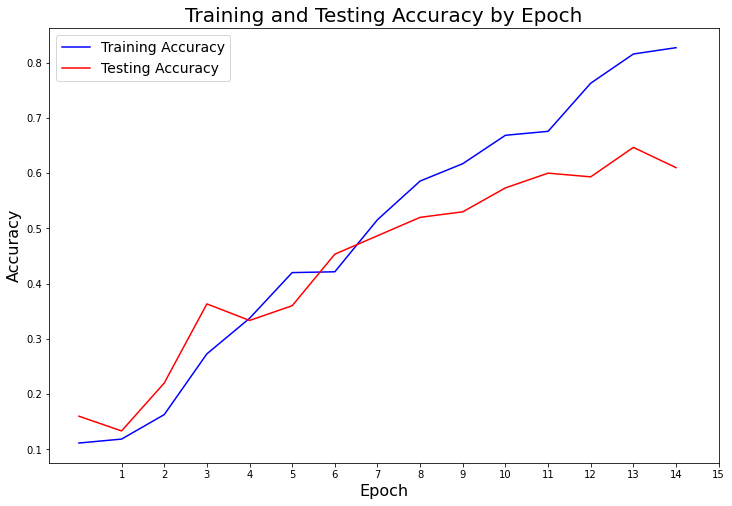

In [ ]:
# The code in this cell was adapted from a lecture at General Assembly

# Check out our train accuracy and test accuracy over epochs.
train_loss = history.history['accuracy']
test_loss = history.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Accuracy', color='blue')
plt.plot(test_loss, label='Testing Accuracy', color='red')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 20)
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Accuracy', fontsize = 16)
plt.xticks(range(1,16), range(1,16))
plt.legend(fontsize = 14)

### Confusion Matrix

In [ ]:
# Checking the number of targets per class
for i in range(10): 
    print(f'{i}: {sum([1 for target in y_test if target[i] == 1])}')

0: 30
1: 30
2: 30
3: 30
4: 30
5: 30
6: 30
7: 30
8: 30
9: 30


In [ ]:
# Checking the number of predicted values in each class
for i in range(10): 
    print(f'{i}: {sum([1 for prediction in predictions if np.argmax(prediction) == i])}')

0: 33
1: 56
2: 7
3: 39
4: 12
5: 44
6: 26
7: 32
8: 16
9: 35


In [ ]:
# Calculating the confusion matrix 
# row: actual
# columns: predicted
conf_matrix = confusion_matrix(np.argmax(y_test, 1), np.argmax(predictions, 1))
conf_matrix

array([[20,  0,  0,  2,  0,  4,  0,  3,  0,  1],
       [ 1, 24,  0,  4,  0,  0,  0,  0,  1,  0],
       [ 2,  4,  4,  6,  0, 11,  0,  0,  1,  2],
       [ 6,  1,  0, 15,  0,  4,  2,  1,  1,  0],
       [ 0, 13,  0,  4, 11,  0,  0,  0,  1,  1],
       [ 4,  0,  0,  3,  0, 22,  0,  0,  0,  1],
       [ 0,  0,  2,  1,  1,  0, 24,  0,  1,  1],
       [ 0,  0,  1,  0,  0,  2,  0, 27,  0,  0],
       [ 0, 10,  0,  4,  0,  1,  0,  0, 11,  4],
       [ 0,  4,  0,  0,  0,  0,  0,  1,  0, 25]])

In [ ]:
# Creating a dataframe of the confusion matrix with labels for readability 
confusion_df = pd.DataFrame(conf_matrix)
confusion_df

,0,1,2,3,4,5,6,7,8,9
0,20,0,0,2,0,4,0,3,0,1
1,1,24,0,4,0,0,0,0,1,0
2,2,4,4,6,0,11,0,0,1,2
3,6,1,0,15,0,4,2,1,1,0
4,0,13,0,4,11,0,0,0,1,1
5,4,0,0,3,0,22,0,0,0,1
6,0,0,2,1,1,0,24,0,1,1
7,0,0,1,0,0,2,0,27,0,0
8,0,10,0,4,0,1,0,0,11,4
9,0,4,0,0,0,0,0,1,0,25


In [ ]:
# Creating a dictionary of labels
labels_dict = {
    0: 'jazz',
    1: 'reggae',
    2: 'rock',
    3: 'blues',
    4: 'hiphop',
    5: 'country',
    6: 'metal',
    7: 'classical',
    8: 'disco',
    9: 'pop'
}

In [ ]:
# Renaming rows and columns with labes
confusion_df = confusion_df.rename(columns=labels_dict)
confusion_df.index = confusion_df.columns
confusion_df

,jazz,reggae,rock,blues,hiphop,country,metal,classical,disco,pop
jazz,20,0,0,2,0,4,0,3,0,1
reggae,1,24,0,4,0,0,0,0,1,0
rock,2,4,4,6,0,11,0,0,1,2
blues,6,1,0,15,0,4,2,1,1,0
hiphop,0,13,0,4,11,0,0,0,1,1
country,4,0,0,3,0,22,0,0,0,1
metal,0,0,2,1,1,0,24,0,1,1
classical,0,0,1,0,0,2,0,27,0,0
disco,0,10,0,4,0,1,0,0,11,4
pop,0,4,0,0,0,0,0,1,0,25


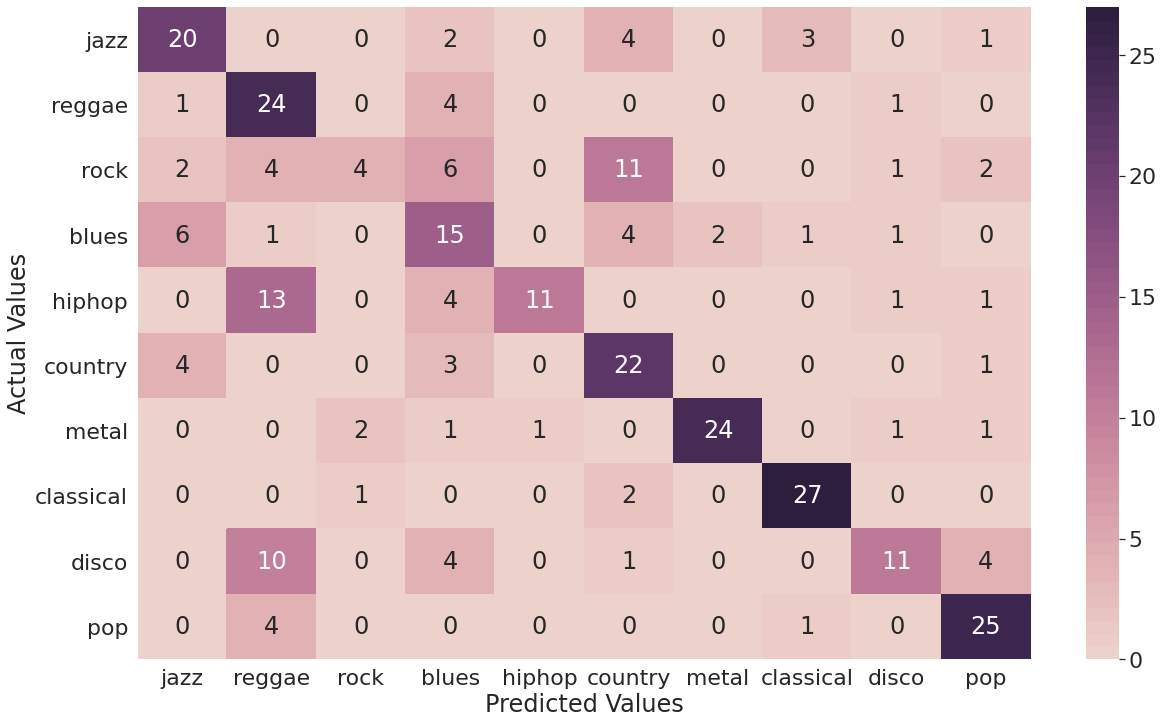

In [ ]:
# Creating a heatmap for the confusion matrix for display
plt.figure(figsize= (20,12))
sns.set(font_scale = 2);
ax = sns.heatmap(confusion_df, annot=True, cmap=sns.cubehelix_palette(50));
ax.set(xlabel='Predicted Values', ylabel='Actual Values');

### Numeric features

In [ ]:
def extract_audio_features(directory):
    
    # Creating an empty list to store all file names
    files = []
    labels = []
    zcrs = []
    spec_centroids = []
    spec_rolloffs = []
    mfccs_1 = []
    mfccs_2 = []
    mfccs_3 = []
    mfccs_4 = []
    mfccs_5 = []
    mfccs_6 = []
    mfccs_7 = []
    mfccs_8 = []
    mfccs_9 = []
    mfccs_10 = []
    mfccs_11 = []
    mfccs_12 = []
    mfccs_13 = []
    
    # Looping through each file in the directory
    for file in os.scandir(directory):
        
        # Loading in the audio file
        y, sr = librosa.core.load(file)
        
        # Adding the file to our list of files
        files.append(str(file))
        
        # Adding the label to our list of labels
        label = str(file).split('.')[0]
        labels.append(str(label))
        
        # Calculating zero-crossing rates
        zcr = librosa.feature.zero_crossing_rate(y)
        zcrs.append(np.mean(zcr))
        
        # Calculating the spectral centroids
        spec_centroid = librosa.feature.spectral_centroid(y)
        spec_centroids.append(np.mean(spec_centroid))
        
        # Calculating the spectral rolloffs
        spec_rolloff = librosa.feature.spectral_rolloff(y)
        spec_rolloffs.append(np.mean(spec_rolloff))
        
        # Calculating the first 13 mfcc coefficients
        mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=512, n_mfcc=13)
        mfcc_scaled = np.mean(mfcc.T, axis=0)
        mfccs_1.append(mfcc_scaled[0])
        mfccs_2.append(mfcc_scaled[1])
        mfccs_3.append(mfcc_scaled[2])
        mfccs_4.append(mfcc_scaled[3])
        mfccs_5.append(mfcc_scaled[4])
        mfccs_6.append(mfcc_scaled[5])
        mfccs_7.append(mfcc_scaled[6])
        mfccs_8.append(mfcc_scaled[7])
        mfccs_9.append(mfcc_scaled[8])
        mfccs_10.append(mfcc_scaled[9])
        mfccs_11.append(mfcc_scaled[10])
        mfccs_12.append(mfcc_scaled[11])
        mfccs_13.append(mfcc_scaled[12])
    
    # Creating a data frame with the values we collected
    df = pd.DataFrame({
        'files': files,
        'zero_crossing_rate': zcrs,
        'spectral_centroid': spec_centroids,
        'spectral_rolloff': spec_rolloffs,
        'mfcc_1': mfccs_1,
        'mfcc_2': mfccs_2,
        'mfcc_3': mfccs_3,
        'mfcc_4': mfccs_4,
        'mfcc_5': mfccs_5,
        'mfcc_6': mfccs_6,
        'mfcc_7': mfccs_7,
        'mfcc_8': mfccs_8,
        'mfcc_9': mfccs_9,
        'mfcc_10': mfccs_10,
        'mfcc_11': mfccs_11,
        'mfcc_12': mfccs_12,
        'mfcc_13': mfccs_13,
        'labels': labels
    })
    
    # Returning the data frame
    return df

In [ ]:
df = extract_audio_features(content_path)

In [ ]:
genre= df.copy()

In [ ]:
genre.head()

,files,zero_crossing_rate,spectral_centroid,spectral_rolloff,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,labels
0,<DirEntry 'blues.00002.wav'>,0.076291,1552.811865,3042.260232,-90.722595,140.446304,-29.093889,31.684334,-13.984504,25.764742,-13.664875,11.639934,-11.783642,9.718760,-13.133803,5.791199,-8.907628,<DirEntry 'blues
1,<DirEntry 'blues.00000.wav'>,0.083045,1784.165850,3805.839606,-113.570648,121.571793,-19.168142,42.366421,-6.364664,18.623499,-13.704891,15.343150,-12.274110,10.976572,-8.326573,8.803793,-3.672300,<DirEntry 'blues
2,<DirEntry 'blues.00005.wav'>,0.094042,1831.993940,3481.517592,-177.774246,118.205482,-17.565880,30.762402,-21.747839,11.920993,-20.730993,3.186578,-8.586039,-0.932852,-11.772434,-2.405832,-9.343665,<DirEntry 'blues
3,<DirEntry 'blues.00003.wav'>,0.033309,1070.106615,2184.745799,-199.544205,150.090912,5.662678,26.859079,1.771399,14.234031,-4.832006,9.286495,-0.759187,8.137607,-3.200653,6.079319,-2.480174,<DirEntry 'blues
4,<DirEntry 'blues.00006.wav'>,0.073052,1459.366472,2795.610963,-190.052368,130.289078,-36.369534,33.029034,11.108783,-0.605584,-20.871855,0.273025,-6.486140,-5.516768,-7.839752,-3.128592,-6.596197,<DirEntry 'blues


## Numeric Prep

In [ ]:
type(genre['files'][2])

str

In [ ]:
genre['files'] = genre['files'].map(lambda x: x[11:-2])
genre['labels'] = genre['labels'].map(lambda x: x[11:])

In [ ]:
# Mapping the labels to numeric values
label_map = {
    'blues': 1,
    'classical': 2,
    'country': 3,
    'disco': 4,
    'hiphop': 5,
    'jazz': 6,
    'metal': 7,
    'pop': 8,
    'reggae': 9,
    'rock': 10
}

genre['y'] = genre['labels'].map(label_map)


In [ ]:
genre.head()

,files,zero_crossing_rate,spectral_centroid,spectral_rolloff,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,labels,y
0,blues.00002.wav,0.076291,1552.811865,3042.260232,-90.722595,140.446304,-29.093889,31.684334,-13.984504,25.764742,-13.664875,11.639934,-11.783642,9.718760,-13.133803,5.791199,-8.907628,blues,1
1,blues.00000.wav,0.083045,1784.165850,3805.839606,-113.570648,121.571793,-19.168142,42.366421,-6.364664,18.623499,-13.704891,15.343150,-12.274110,10.976572,-8.326573,8.803793,-3.672300,blues,1
2,blues.00005.wav,0.094042,1831.993940,3481.517592,-177.774246,118.205482,-17.565880,30.762402,-21.747839,11.920993,-20.730993,3.186578,-8.586039,-0.932852,-11.772434,-2.405832,-9.343665,blues,1
3,blues.00003.wav,0.033309,1070.106615,2184.745799,-199.544205,150.090912,5.662678,26.859079,1.771399,14.234031,-4.832006,9.286495,-0.759187,8.137607,-3.200653,6.079319,-2.480174,blues,1
4,blues.00006.wav,0.073052,1459.366472,2795.610963,-190.052368,130.289078,-36.369534,33.029034,11.108783,-0.605584,-20.871855,0.273025,-6.486140,-5.516768,-7.839752,-3.128592,-6.596197,blues,1


In [ ]:
# Defining our features and predictor variable
X = genre.drop(['files',  'labels','y'], axis=1)
y = genre['y']

In [ ]:
# Getting our baseline accuracy
y.value_counts(normalize=True)

10    0.1
9     0.1
8     0.1
7     0.1
6     0.1
5     0.1
4     0.1
3     0.1
2     0.1
1     0.1
Name: y, dtype: float64

### SVM

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [ ]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
# Scaling the features after train_test_split to avoid data leak
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [ ]:
# Instantiating and fitting a basic svc model
svc = SVC()
svc.fit(X_train_sc, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
# Checking the accuracy
print(f'Score on the training set: {svc.score(X_train_sc, y_train)}')
print(f'Score on the test set: {svc.score(X_test_sc, y_test)}')

Score on the training set: 0.6928571428571428
Score on the test set: 0.58


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
svc_pred = svc.predict(X_test_sc)
confusion_matrix(y_test, svc_pred)

array([[22,  0,  1,  1,  0,  0,  5,  0,  0,  1],
       [ 0, 29,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 3,  0, 12,  0,  2,  7,  1,  2,  3,  0],
       [ 1,  1,  1,  9,  2,  0,  1,  7,  2,  6],
       [ 0,  0,  2,  6, 13,  0,  0,  1,  6,  2],
       [ 1,  3,  2,  1,  2, 18,  0,  0,  2,  1],
       [ 3,  0,  0,  1,  1,  0, 24,  0,  0,  1],
       [ 0,  1,  2,  3,  2,  1,  0, 20,  1,  0],
       [ 0,  0,  2,  1,  3,  3,  0,  2, 17,  2],
       [ 8,  0,  2,  5,  2,  0,  2,  0,  1, 10]])

In [ ]:
print(classification_report(y_test, svc_pred))

              precision    recall  f1-score   support

           1       0.58      0.73      0.65        30
           2       0.85      0.97      0.91        30
           3       0.50      0.40      0.44        30
           4       0.33      0.30      0.32        30
           5       0.48      0.43      0.46        30
           6       0.60      0.60      0.60        30
           7       0.73      0.80      0.76        30
           8       0.62      0.67      0.65        30
           9       0.53      0.57      0.55        30
          10       0.43      0.33      0.38        30

    accuracy                           0.58       300
   macro avg       0.57      0.58      0.57       300
weighted avg       0.57      0.58      0.57       300



In [ ]:
'''Tuning SVM with grid search'''
from sklearn.model_selection import GridSearchCV

svm_param = {'C':[0.5, 1, 4, 8, 12], 
            'gamma': [1, 0.5, 0.1, 0.05],
             'kernel': ['rbf', 'poly', 'sigmoid'],
            'degree': [0, 1, 2]}
gscv = GridSearchCV(svc, svm_param, refit=True, verbose=2)
gscv.fit(X_train_sc, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV] C=0.5, degree=0, gamma=1, kernel=rbf ............................
[CV] ............. C=0.5, degree=0, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.5, degree=0, gamma=1, kernel=rbf ............................
[CV] ............. C=0.5, degree=0, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.5, degree=0, gamma=1, kernel=rbf ............................
[CV] ............. C=0.5, degree=0, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.5, degree=0, gamma=1, kernel=rbf ............................
[CV] ............. C=0.5, degree=0, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.5, degree=0, gamma=1, kernel=rbf ............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ............. C=0.5, degree=0, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.5, degree=0, gamma=1, kernel=poly ...........................
[CV] ............ C=0.5, degree=0, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.5, degree=0, gamma=1, kernel=poly ...........................
[CV] ............ C=0.5, degree=0, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.5, degree=0, gamma=1, kernel=poly ...........................
[CV] ............ C=0.5, degree=0, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.5, degree=0, gamma=1, kernel=poly ...........................
[CV] ............ C=0.5, degree=0, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.5, degree=0, gamma=1, kernel=poly ...........................
[CV] ............ C=0.5, degree=0, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.5, degree=0, gamma=1, kernel=sigmoid ........................
[CV] ......... C=0.5, degree=0, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.5, degree=0, gamma=1, kernel=sigmoid ........................
[CV] .

[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed:   31.3s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.5, 1, 4, 8, 12], 'degree': [0, 1, 2],
                         'gamma': [1, 0.5, 0.1, 0.05],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [ ]:
print(gscv.best_estimator_)

SVC(C=4, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=0, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [ ]:
gscv_pred = gscv.predict(X_test_sc)
confusion_matrix(y_test, gscv_pred)

array([[26,  0,  2,  0,  1,  0,  1,  0,  0,  0],
       [ 0, 28,  0,  0,  0,  2,  0,  0,  0,  0],
       [ 3,  0, 18,  0,  1,  3,  0,  1,  3,  1],
       [ 0,  1,  1, 15,  3,  2,  0,  3,  2,  3],
       [ 0,  0,  1,  3, 18,  1,  0,  1,  3,  3],
       [ 3,  2,  2,  1,  1, 18,  0,  0,  3,  0],
       [ 2,  0,  0,  2,  2,  0, 23,  0,  0,  1],
       [ 0,  1,  2,  1,  2,  1,  0, 20,  2,  1],
       [ 0,  0,  1,  1,  3,  4,  0,  2, 17,  2],
       [ 1,  1,  1,  4,  1,  3,  1,  0,  0, 18]])

In [ ]:
print(classification_report(y_test, gscv_pred))

              precision    recall  f1-score   support

           1       0.74      0.87      0.80        30
           2       0.85      0.93      0.89        30
           3       0.64      0.60      0.62        30
           4       0.56      0.50      0.53        30
           5       0.56      0.60      0.58        30
           6       0.53      0.60      0.56        30
           7       0.92      0.77      0.84        30
           8       0.74      0.67      0.70        30
           9       0.57      0.57      0.57        30
          10       0.62      0.60      0.61        30

    accuracy                           0.67       300
   macro avg       0.67      0.67      0.67       300
weighted avg       0.67      0.67      0.67       300



### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# Checking the accuracy
print(f'Score on the training set: {rf.score(X_train, y_train)}')
print(f'Score on the test set: {rf.score(X_test, y_test)}')

Score on the training set: 0.9985714285714286
Score on the test set: 0.5766666666666667


In [ ]:
rf_pred = rf.predict(X_test)
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           1       0.71      0.73      0.72        30
           2       0.78      0.83      0.81        30
           3       0.45      0.47      0.46        30
           4       0.50      0.43      0.46        30
           5       0.47      0.47      0.47        30
           6       0.46      0.53      0.49        30
           7       0.76      0.73      0.75        30
           8       0.60      0.70      0.65        30
           9       0.64      0.53      0.58        30
          10       0.38      0.33      0.36        30

    accuracy                           0.58       300
   macro avg       0.57      0.58      0.57       300
weighted avg       0.57      0.58      0.57       300



In [ ]:
'''Tuning RF with grid search'''

from sklearn.model_selection import GridSearchCV# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [20, 40, 60, 80, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [2, 4, 6],
    'min_samples_split': [4, 8, 12],
    'n_estimators': [100, 300, 600, 1000, 1500]
}
# Create a based model
# rf = RandomForestRegressor()# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 4, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 540 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   52.8s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed: 22.8min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 33.1min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed: 45.2min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed: 49.2min finished


GridSearchCV(cv=4, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 600}

In [ ]:
rf_grid_pred = grid_search.predict(X_test)
print(classification_report(y_test, rf_grid_pred))

              precision    recall  f1-score   support

           1       0.74      0.77      0.75        30
           2       0.78      0.93      0.85        30
           3       0.46      0.43      0.45        30
           4       0.41      0.30      0.35        30
           5       0.47      0.47      0.47        30
           6       0.45      0.50      0.48        30
           7       0.82      0.77      0.79        30
           8       0.51      0.67      0.58        30
           9       0.61      0.57      0.59        30
          10       0.48      0.40      0.44        30

    accuracy                           0.58       300
   macro avg       0.57      0.58      0.57       300
weighted avg       0.57      0.58      0.57       300



### FFNN using mfcc

In [ ]:
# mfcc data
genre.tail()

,files,zero_crossing_rate,spectral_centroid,spectral_rolloff,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,labels,y
995,rock.00090.wav,0.120636,2495.723202,5213.208461,-88.981575,86.208252,-24.397999,47.084251,-33.652267,29.450218,-19.743584,21.626024,-16.739435,6.527689,-13.384119,7.481564,-12.840421,rock,10
996,rock.00098.wav,0.048724,1398.699344,3015.631004,-225.007751,123.646751,-9.724174,56.605164,10.436499,20.622280,-10.253696,15.561657,-8.227290,12.800150,-9.001975,7.682843,-10.070732,rock,10
997,rock.00095.wav,0.089227,2008.149458,4253.557033,-153.640961,109.864647,-23.065697,59.050137,-7.475873,19.726795,-16.484838,18.066439,-22.202003,15.409105,-12.372051,12.348828,-12.297895,rock,10
998,rock.00096.wav,0.097664,2006.843354,4149.338328,-142.392029,116.189629,-32.147167,49.117847,-8.373376,22.882061,-18.315985,20.098146,-22.093319,10.798820,-12.979385,14.080058,-16.392994,rock,10
999,rock.00091.wav,0.150135,2474.257423,4754.174861,-74.275742,100.125725,-47.363968,49.617355,-18.413784,24.616348,-15.919292,23.896038,-22.835342,23.332420,-16.944992,14.934316,-11.496364,rock,10


In [ ]:
# Need to redo label_map, label starting from 0
# this allows correct dimension after one hot encoding 
# Mapping the labels to numeric values
label_map = {
    'blues': 0,
    'classical': 1,
    'country': 2,
    'disco': 3,
    'hiphop': 4,
    'jazz': 5,
    'metal': 6,
    'pop': 7,
    'reggae': 8,
    'rock': 9
}

genre2 = genre
genre2['y'] = genre['labels'].map(label_map)

In [ ]:
genre2.tail()

,files,zero_crossing_rate,spectral_centroid,spectral_rolloff,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,labels,y
995,rock.00090.wav,0.120636,2495.723202,5213.208461,-88.981575,86.208252,-24.397999,47.084251,-33.652267,29.450218,-19.743584,21.626024,-16.739435,6.527689,-13.384119,7.481564,-12.840421,rock,9
996,rock.00098.wav,0.048724,1398.699344,3015.631004,-225.007751,123.646751,-9.724174,56.605164,10.436499,20.622280,-10.253696,15.561657,-8.227290,12.800150,-9.001975,7.682843,-10.070732,rock,9
997,rock.00095.wav,0.089227,2008.149458,4253.557033,-153.640961,109.864647,-23.065697,59.050137,-7.475873,19.726795,-16.484838,18.066439,-22.202003,15.409105,-12.372051,12.348828,-12.297895,rock,9
998,rock.00096.wav,0.097664,2006.843354,4149.338328,-142.392029,116.189629,-32.147167,49.117847,-8.373376,22.882061,-18.315985,20.098146,-22.093319,10.798820,-12.979385,14.080058,-16.392994,rock,9
999,rock.00091.wav,0.150135,2474.257423,4754.174861,-74.275742,100.125725,-47.363968,49.617355,-18.413784,24.616348,-15.919292,23.896038,-22.835342,23.332420,-16.944992,14.934316,-11.496364,rock,9


In [ ]:
# Defining our features and predictor variable
X2 = genre2.drop(['files',  'labels','y'], axis=1)
y2 = genre2['y']

In [ ]:
X_arr = X2.to_numpy()
X_arr[999]
# this means X_arr has 1000 rows, perfect

array([ 1.50134589e-01,  2.47425742e+03,  4.75417486e+03, -7.42757416e+01,
        1.00125725e+02, -4.73639679e+01,  4.96173553e+01, -1.84137840e+01,
        2.46163483e+01, -1.59192924e+01,  2.38960381e+01, -2.28353424e+01,
        2.33324203e+01, -1.69449921e+01,  1.49343157e+01, -1.14963636e+01])

In [ ]:
# we have 1000 instances in target feature
y_arr = y2.to_numpy()
y_arr.shape

(1000,)

In [ ]:
# train test split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_arr, y_arr, random_state=42, stratify=y, test_size=.3)

In [ ]:
# One hot encoding our labels
y_train2 = to_categorical(y_train2)
y_test2 = to_categorical(y_test2)

In [ ]:
y_test2.shape

(300, 10)

In [ ]:
# Need to reshape x to fit into cnn
X_train2 = X_train2.reshape(X_train2.shape[0], 16, 1)
X_test2 = X_test2.reshape(X_test2.shape[0], 16, 1)

In [ ]:
# Initializing a random seed for replication purposes
np.random.seed(1)

model2 = Sequential()
model2.add(Flatten(input_shape = (16, 1)))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(56, activation='relu'))
# model2.add(Dense(48, activation='relu'))
model2.add(Dense(10, activation='softmax'))

model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                1088      
_________________________________________________________________
dense_7 (Dense)              (None, 56)                3640      
_________________________________________________________________
dense_8 (Dense)              (None, 10)                570       
Total params: 5,298
Trainable params: 5,298
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fitting our neural network
history2 = model2.fit(X_train2,
                    y_train2, 
                    batch_size=20,
                    validation_data=(X_test2, y_test2),
                    epochs=30)

Epoch 1/30
35/35 [==============================] - 1s 9ms/step - loss: 342.2832 - accuracy: 0.0989 - val_loss: 37.0768 - val_accuracy: 0.0833
Epoch 2/30
35/35 [==============================] - 0s 3ms/step - loss: 26.0289 - accuracy: 0.1118 - val_loss: 15.1808 - val_accuracy: 0.2067
Epoch 3/30
35/35 [==============================] - 0s 3ms/step - loss: 13.7815 - accuracy: 0.2050 - val_loss: 14.3206 - val_accuracy: 0.1833
Epoch 4/30
35/35 [==============================] - 0s 3ms/step - loss: 15.4825 - accuracy: 0.2079 - val_loss: 23.1509 - val_accuracy: 0.2500
Epoch 5/30
35/35 [==============================] - 0s 3ms/step - loss: 21.5610 - accuracy: 0.2400 - val_loss: 13.6351 - val_accuracy: 0.1467
Epoch 6/30
35/35 [==============================] - 0s 3ms/step - loss: 15.2660 - accuracy: 0.2497 - val_loss: 11.6304 - val_accuracy: 0.3400
Epoch 7/30
35/35 [==============================] - 0s 4ms/step - loss: 13.8109 - accuracy: 0.2578 - val_loss: 16.4255 - val_accuracy: 0.2400
Epoch

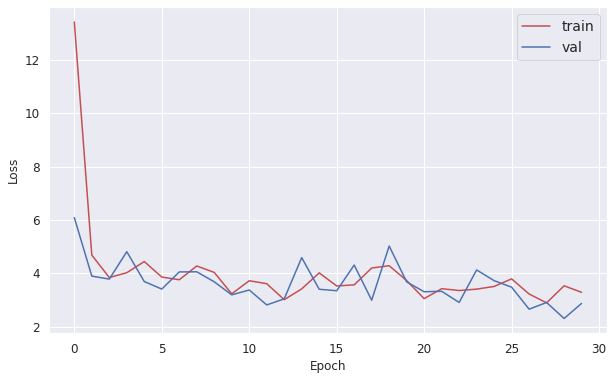

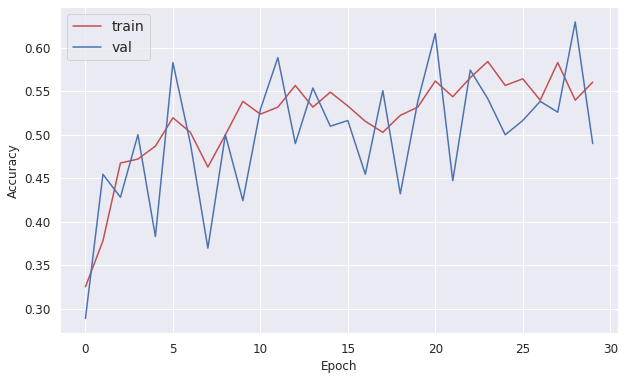

In [ ]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history2.history['loss']), 'r', label='train')
ax.plot(np.sqrt(history2.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=12)
ax.set_ylabel(r'Loss', fontsize=12)
ax.legend(fontsize = 14)
ax.tick_params(labelsize=12)

# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history2.history['accuracy']), 'r', label='train')
ax.plot(np.sqrt(history2.history['val_accuracy']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=12)
ax.set_ylabel(r'Accuracy', fontsize=12)
ax.legend(fontsize = 14)
ax.tick_params(labelsize=12)